# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [8]:
#Make allNecessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import librosa
import librosa.display
import plotly.express as px
import glob
import os
from google.colab import drive
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [9]:
drive.mount('/content/drive')

# Load the Data
unlabelled_data_path = '/content/drive/MyDrive/unlabelled_sounds/'

# Get all .wav files
audio_files = glob.glob(unlabelled_data_path + "*.wav")

print(f"Found {len(audio_files)} audio files.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3020 audio files.


In [10]:
def extract_mel_features(file_path, n_mels=128):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        return np.mean(log_mel_spec, axis=1)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


We used n_mels=128 in the Mel spectrogram because it provides a good balance between frequency resolution and computational efficiency. It's commonly used in audio ML tasks and keeps the feature space manageable (128 dimensions per file), making it suitable for clustering and visualization.


In [11]:
# Process all .wav file
features = []
file_names = []

for file in tqdm(audio_files):
    mel_feat = extract_mel_features(file)
    if mel_feat is not None:
        features.append(mel_feat)
        file_names.append(os.path.basename(file))


100%|██████████| 3020/3020 [01:36<00:00, 31.40it/s]


In [12]:
# Convert to DataFrame
feature_df = pd.DataFrame(features)
feature_df['filename'] = file_names

# Save to CSV
unlabelled_data_csv = '/content/drive/MyDrive/unlabelled_sounds/features.csv'
feature_df.to_csv(unlabelled_data_csv, index=False)

print(f"Features saved to {unlabelled_data_csv}")


Features saved to /content/drive/MyDrive/unlabelled_sounds/features.csv


In [13]:
df = pd.read_csv(unlabelled_data_csv)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,filename
0,-40.264046,-41.559483,-41.589924,-44.130516,-41.393780,-31.652899,-15.302740,-11.936417,-11.138722,-11.654714,...,-36.643227,-38.773030,-44.012090,-47.513783,-47.582730,-47.342720,-47.380238,-52.535107,-53.171684,1217.wav
1,-78.162250,-80.000000,-80.000000,-79.826890,-78.603870,-64.753700,-54.626823,-30.117188,-20.022959,-26.770124,...,-33.379284,-36.036484,-33.805763,-34.416737,-36.809967,-39.517868,-42.628720,-51.174380,-65.333020,1625.wav
2,-66.663910,-63.397705,-55.656452,-52.529460,-39.618660,-23.335733,-21.306917,-27.337215,-25.770369,-33.140750,...,-47.934000,-44.942090,-40.144512,-40.549550,-39.298270,-42.517277,-43.061337,-48.810833,-49.902714,597.wav
3,-63.826252,-62.155340,-60.601807,-57.244804,-36.745113,-18.015896,-18.422873,-36.229380,-34.918427,-30.203188,...,-50.134075,-50.997400,-49.434914,-48.359295,-44.864490,-45.543800,-48.228783,-48.129215,-51.775425,808.wav
4,-43.098957,-40.452625,-37.511820,-39.938060,-25.264853,-6.604174,-11.182484,-27.977380,-31.851202,-29.571222,...,-42.899265,-42.232464,-42.759690,-43.482956,-44.219025,-45.077830,-48.421284,-50.664020,-50.787533,1250.wav


In [14]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,...,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,-51.139282,-52.031931,-49.742662,-48.180815,-40.326061,-29.627189,-26.889465,-26.292157,-26.948407,-28.427722,...,-42.819464,-43.012023,-43.240380,-43.669121,-44.532219,-45.337524,-46.176441,-47.674493,-50.894418,-54.934258
std,17.594323,14.001990,13.077935,13.970374,16.175046,15.839816,13.932360,9.085101,8.169222,7.786380,...,8.703113,8.940789,9.179635,9.391522,9.708725,10.027367,10.135742,10.101085,9.912771,11.466850
min,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-75.988600,-67.302840,-66.598090,-62.152447,-57.298862,...,-73.464806,-72.245930,-72.365300,-72.716970,-73.201050,-74.258865,-76.307340,-75.637400,-77.317474,-80.000000
25%,-67.286142,-63.568688,-57.166000,-55.044485,-44.398556,-35.303209,-33.030698,-32.393528,-32.614506,-33.806732,...,-48.951593,-49.708982,-50.150925,-50.798244,-51.763378,-53.022166,-53.950875,-55.417450,-58.592021,-63.292961
50%,-50.234827,-47.237906,-45.210345,-44.792962,-36.542006,-24.625657,-23.909110,-26.578028,-26.778678,-28.468213,...,-42.568613,-42.324576,-42.311884,-42.736230,-43.625670,-44.473353,-45.579636,-47.539732,-51.183105,-54.573433
75%,-40.387792,-40.800606,-40.388451,-39.561662,-29.930948,-18.409684,-16.933234,-19.949015,-20.892218,-22.964150,...,-36.311224,-36.269490,-36.200747,-36.398330,-36.837673,-37.091234,-38.054751,-39.458194,-43.906678,-48.664582
max,-13.163022,-19.959187,-15.383888,-11.840691,-3.813078,-5.165038,-1.799205,-3.174175,-4.053774,-4.253669,...,-16.067577,-17.155690,-17.377190,-18.528555,-19.105930,-18.706373,-18.695198,-19.745712,-26.265747,-26.663910


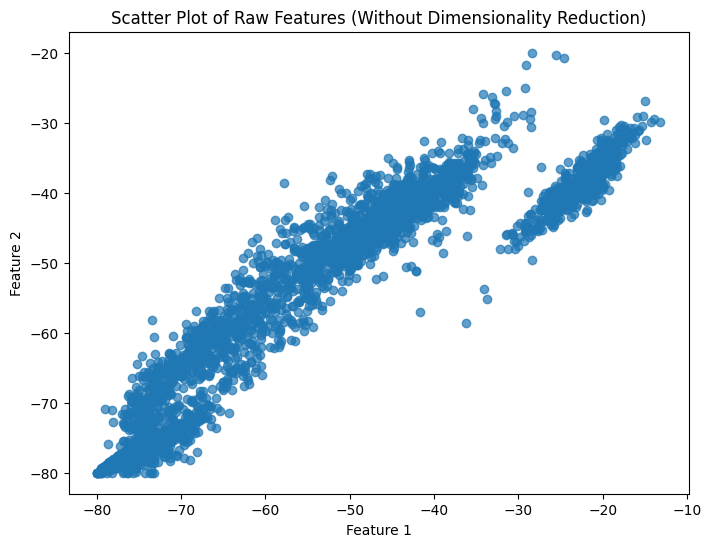

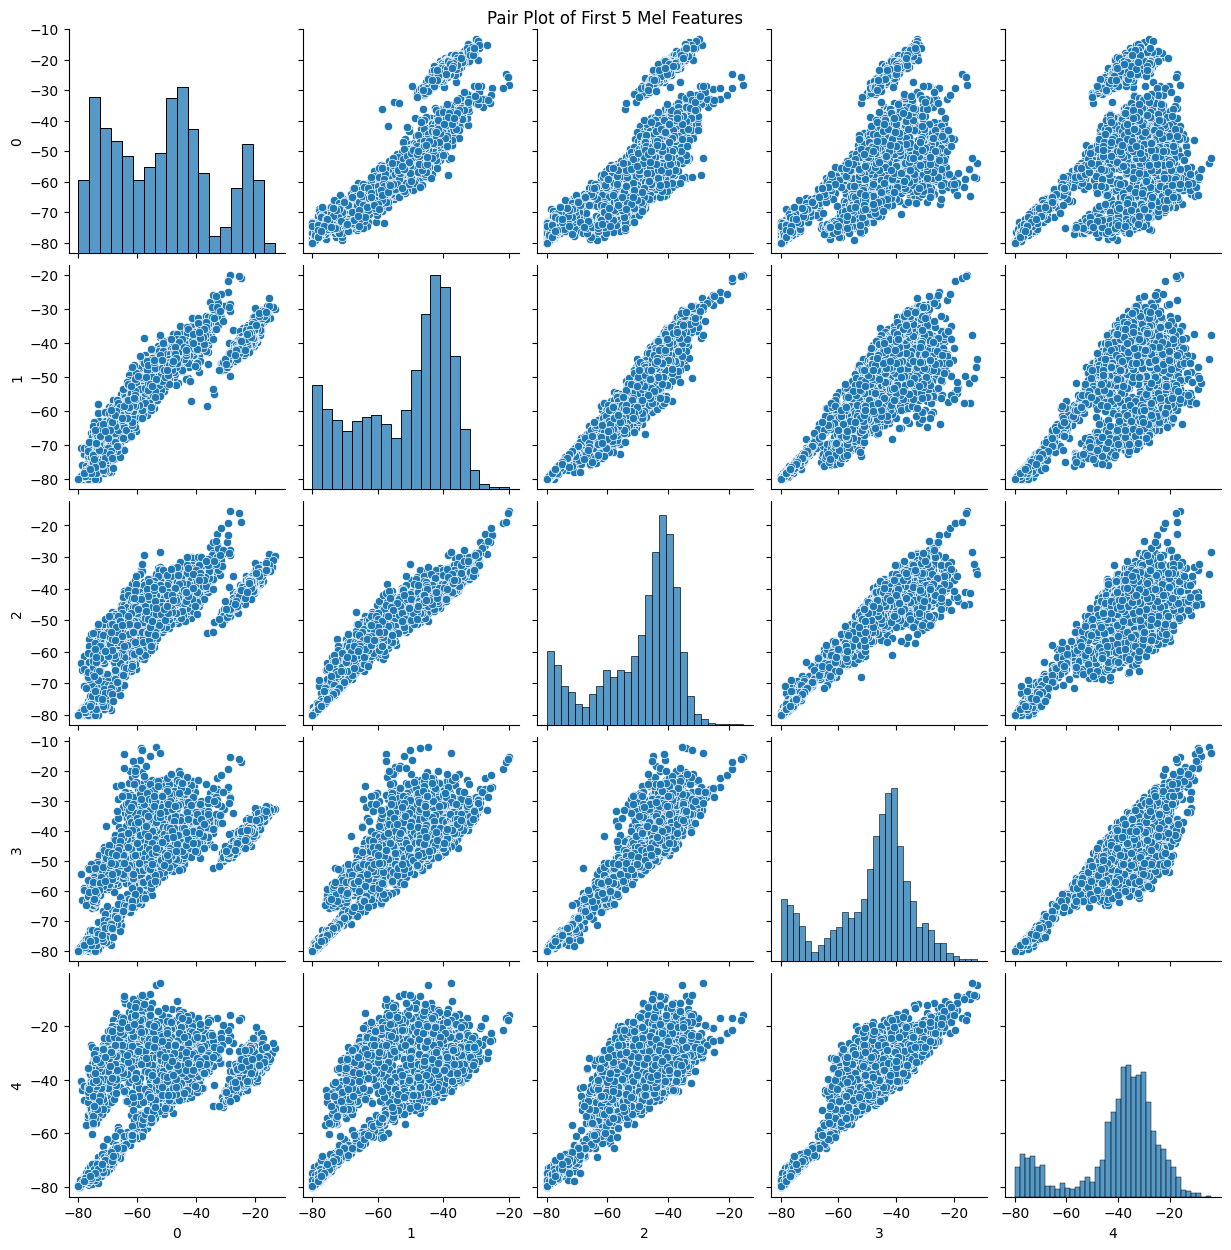

In [15]:
# Scatter plot (Attempt without dimensionality reduction)
# Drop filename column, keep only numeric features
feature_data = df.iloc[:, :-1]
plt.figure(figsize=(8,6))
plt.scatter(feature_data.iloc[:, 0], feature_data.iloc[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df_2= feature_data.iloc[:, :5]
sns.pairplot(df_2)
plt.suptitle("Pair Plot of First 5 Mel Features", y=1)
plt.show()

### Why is dimensionality reduction important?

So when I did plotted this plots I was confused, I was seeing some patterns but they were irrelevant because they didn't give me a anything to interpret. So Dimensionality reduction is very important due to changing the dimension of the dataset from 128D to 2D or 3D depends on which you want and instead of deal with all 128D it reduce them to 2D or 3D while preserving the dataset core structure. So dimensionality reduction give us a proper way to visualize and understand our data than doing it like we did above.

In [16]:
# Apply PCA (3 components)
pca =PCA(n_components=3)
features_pca = pca.fit_transform(feature_data)

print("PCA result shape:", features_pca.shape)


# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
features_tsne = tsne.fit_transform(feature_data)

print("t-SNE result shape:", features_tsne.shape)


PCA result shape: (3020, 3)
t-SNE result shape: (3020, 3)


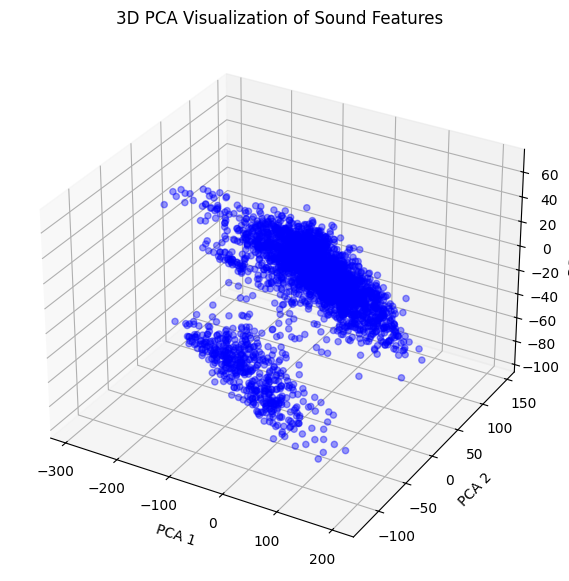

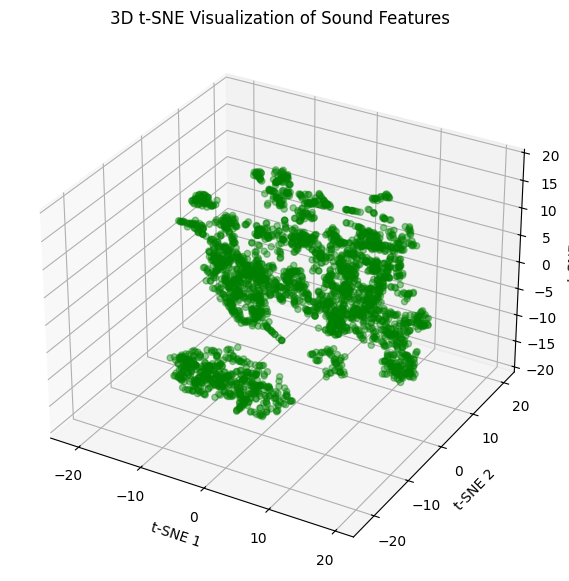

In [17]:
# 3D Visualization goes here

# PCA 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='blue', alpha=0.4)
ax.set_title("3D PCA Visualization of Sound Features")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

# t-SNE 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='green', alpha=0.4)
ax.set_title("3D t-SNE Visualization of Sound Features")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?

Basically the t-SNE did better to what I have observed and it aligns to what we want and I think the PCA didn't do better because generally it focuses on the global structures rather than the local one which t-SNE does and make it more easy and understandable to read. Both are 3D plots, Although the t-SNE did better I still struggle to read what I see but overall the clusters are better separated compared to PCA

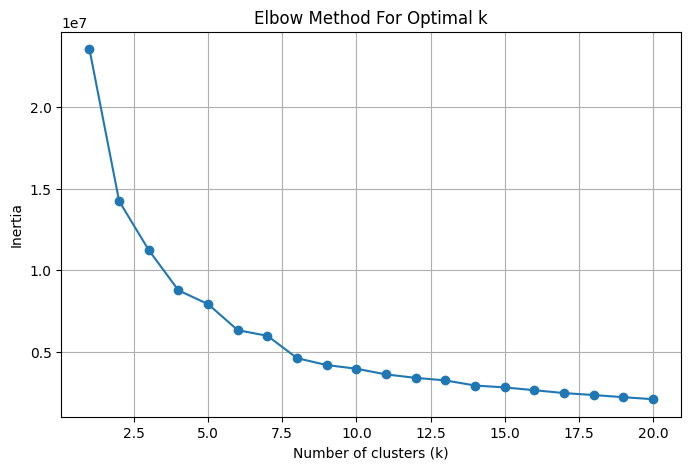

In [18]:
# Optimize number of clusters using Elbow Method

inertia = []
K = range(1, 21)

for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
  kmeans.fit(features_pca)
  inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


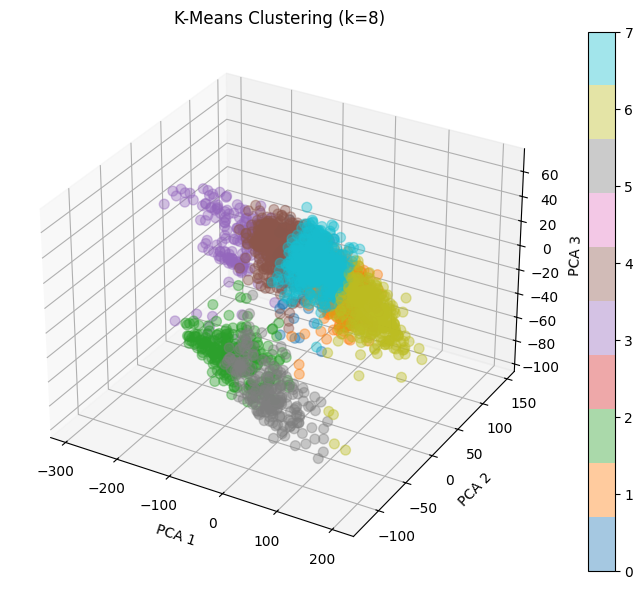

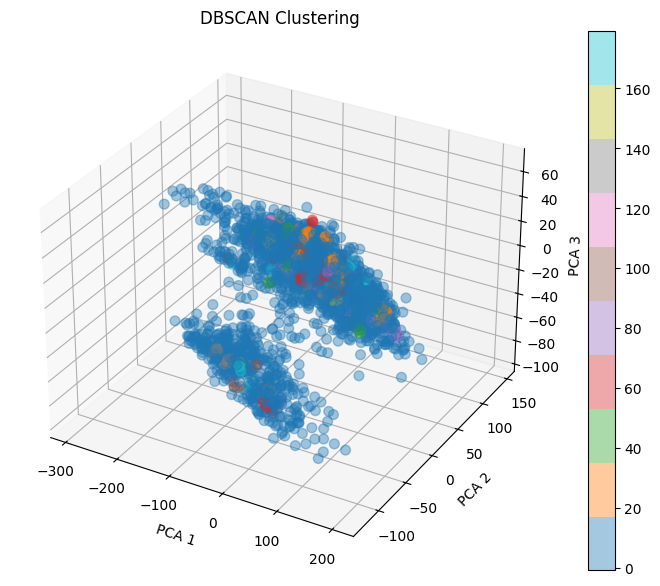

In [25]:

# Select optimal K based on elbow method
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
    c=kmeans_labels, cmap='tab10', s=50, alpha=0.4
)
ax.set_title(f"K-Means Clustering (k={optimal_k})")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.colorbar(scatter, ax=ax)
plt.show()


# Scatter Plot for DBSCAN Clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
    c=dbscan_labels, cmap='tab10', s=50, alpha=0.4
)
ax.set_title("DBSCAN Clustering")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.colorbar(scatter, ax=ax)
plt.show()


In [20]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = -1
    dbscan_db_index = float('inf')
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.3460, Davies-Bouldin Index: 0.8863
DBSCAN - Silhouette Score: -0.4790, Davies-Bouldin Index: 1.2545


### Discuss the results (max 5 lines)

At first on the daigrams, the K-Means showed better results on clustering showing different clusters but the DBSCAN was not clear and lacked clear separation of clusters and showed that K-Means was doing better than DBSCAN, and when I did the evaluation using silhouettte_score and davies_bouldin_score K-Mean did better as I expected than the DBSCAN, The silhouette score (0.3460 vs -0.4241) K-Means shows moderate cluster separation while DBSCAN which is negative means that it grouged unrelated points. For Davies-Bouldin Index (0.8863 vs 1.6687) K-means was lower which means its clusters better separated but the DBSCAN struggled.

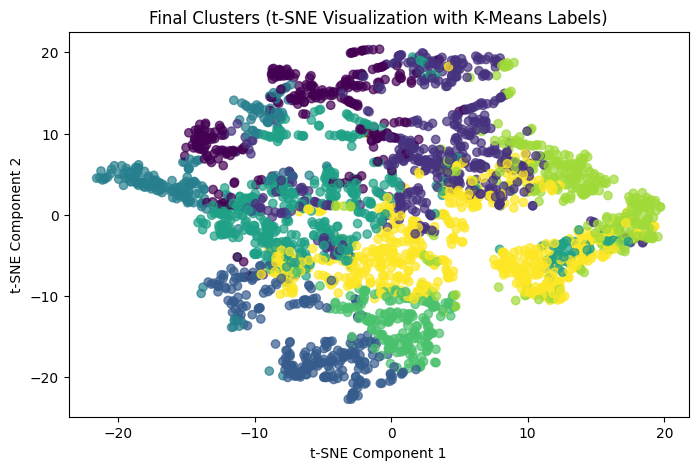

In [21]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
    *  Dimensionality Reduction helped because at first when I plotted without dimensionality reduction it was too much to see and unclear. After applying PCA, the most important features were preserved while removing noise and redundancy. This led to better separation of clusters when applying K-Means.

- Justify why certain clustering methods worked better.
    * K-Means worked better than DBSCAN in my case. The silhouette score and Davies-Bouldin index were better for K-Means, which means the clusters separate. DBSCAN gave a negative silhouette score and high DB index, so it didn't group the data well. I think this is because K-Means works well because the data had some level of separation and balanced group sizes after PCA. DBSCAN didn't do well maybe because the data wasn't dense enough that DBSCAN can form small groups.


- Relate findings to real-world clustering challenges.
    * Since this was my first time working with clustering, I didn't really know how it works in real-life at the beginning. But after trying both K-Means and DBSCAN on this sound data, I can now imagine that in the real world, it might be difficult to group things like sounds or voices. But again using these technques at the fullest can give good results. The data had a lot of features, so we had to reduce it first with PCA, maybe in real projects they also do this to make things easier for the algorithm. Now I see that choosing the right method really matters, because DBSCAN didn't work well for me, and I think that might also happen in real situations when the data is messy or not clearly grouped.
